# Autograd

Based on **Patric Loeber** video: https://www.youtube.com/watch?v=c36lUUr864M&t=1562s

In [1]:
import torch

In [2]:
x = torch.randn(3)
# tensor with 3 random values
print(x)

tensor([-0.0257,  0.8093, -0.0591])


later we want to calculate the gradients of some function with respect to x. What we have to do is we must specify the argument requires_grad=True. By default it is False. We can see that PyTorch tracks that it requires the gradient. Whenever we do operations with this tensor PyTorch will create a so-called computational graph for us.

In [3]:
x = torch.randn(3, requires_grad=True)
# tensor with 3 random values
print(x)

tensor([ 1.5629, -1.6332, -1.0643], requires_grad=True)


Now let's say we do the operation x + 2 and we store this in an output. Then this will create the computational graph which looks like image below. For each operation we have a node with inputs and an output. Here the operation is the plus, our inputs are x and 2, the output is y. With this graph and the technique that is called backpropagation we can then calculate the gradients.

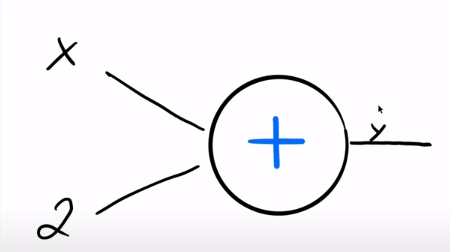

For now it is fine to just know how we can use it. First we do a forward pass, so here we apply this operation and in the forward pass we calculate the output y. Since we specified that it requires the gradient, PyTorch will then automatically create and store a function for us. This function is then used in the backpropagation to get the gradients. Here y has an attribute grad underscore fn, this will point to a gradient function. In this case it is called add backward. With this function we can then calculate the gradients in the so-called backward path. Backward path will calculate the gradient of y with respect to x in this case.

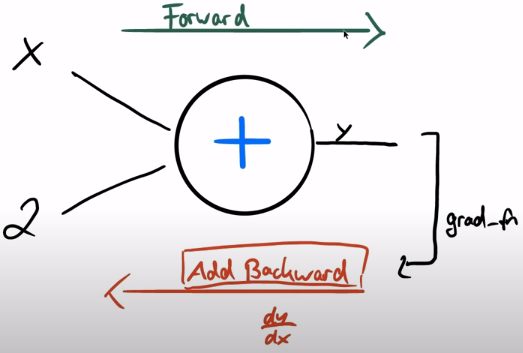

In [16]:
y = x + 2
# after printing y we will see grad_fn attribute, here this is AddBackward function
print(y)

tensor([3.5629, 0.3668, 0.9357], grad_fn=<AddBackward0>)


In [17]:
z = y*y*2
# this tensor also has this grad function attribute
print(z)

tensor([25.3888,  0.2691,  1.7512], grad_fn=<MulBackward0>)


In [18]:
z = z.mean()
# now our grad_fn attribute is MeanBackward
print(z)

tensor(9.1364, grad_fn=<MeanBackward0>)


Now when we want to calculate the gradients the only thing that we must do is to call backward(). This will calculate the gradient of z with respect to x. X then has a gradient, grad() attribute where the gradients are stored.

In [19]:
z.backward() # dz/dx
print(x.grad)

tensor([9.5011, 0.9781, 2.4953])


One thing that we should also know is that in the background what this basically does this will create a so-called vector Jacobian product to get the gradients. THis will look like image below. First item is the Jacobian matrix with the partial derivatives and then we multiply this with a gradient vector and then we will get the final gradients that we are interested in. This is also called the chain rule. We should know that actually we must multiply it with a vector. In this case since our z is a scaar value we don't have to use an arhument in backward() function.

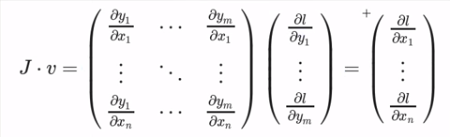

Let's say we didn't apply the mean operation and our z2 is z before applying it. Now when we try to call backward function like before z.backward() will produce an error. Grad can be implicitly created only for scalar outputs. In this case we have to give it the gradient argument. We have to create a vector of the same size. And pass this vector to our backward function.

In [22]:
z2=y*y*2
print(z2)
v = torch.tensor([0.1, 1.0, 0.001], dtype=torch.float32)
z2.backward(v)
print(x.grad)

tensor([25.3888,  0.2691,  1.7512], grad_fn=<MulBackward0>)
tensor([12.3515,  3.9124,  2.5028])


How to prevent PyTorch from tracking the history and calculating this grad_fn attribute. For example sometimes during our training loop when we want to update our weights. This operation should not be part of the gradient computation. For now we should know how we can prevent this from tracking the gradients and we have three options for this.

+ First one is to call the x.requires_grad_(False) function and set it to False
+ The second option is to call x.detach(), this will create a new tensor that doesn't require the gradient.
+ The third option would be to wrap this in a with statement; with torch.no_grad():, and then we can do our operations

In [27]:
x = torch.randn(3, requires_grad=True)
print(x)
"""
Whenever a function has a trailing underscore in PyTorch
then this means that it will modify our variable in place.
"""
x.requires_grad_(False)
print(x)

tensor([-0.3559,  0.6434, -2.7913], requires_grad=True)
tensor([-0.3559,  0.6434, -2.7913])


In [26]:
x = torch.randn(3, requires_grad=True)
y = x.detach()
print(x)
print(y)

tensor([-0.9793,  1.0915, -0.7962], requires_grad=True)
tensor([-0.9793,  1.0915, -0.7962])


In [29]:
x = torch.randn(3, requires_grad=True)
print(x)
with torch.no_grad():
    y = x + 2
    print(y)

tensor([ 1.3128, -0.9003,  0.0773], requires_grad=True)
tensor([3.3128, 1.0997, 2.0773])


Whenever we call the backward function then the gradient for this tensor will be accumulated into the dot grad atribute. So their values will be summed up. We must be very careful.## Dummy training example

## Dummy training example

In [31]:
import torch

weights = torch.ones(4, requires_grad=True)

# training loop
for epoch in range(1):
    model_output = (weights*3).sum()
    
    model_output.backward()
    
    print(weights.grad)

tensor([3., 3., 3., 3.])


In [33]:
"""
if we add another iteration then the second backward call will again accumulate
the values and write them into the grad. All the values are summed up. Now our weights or our gradients are clearly incorrect.
"""
import torch

weights = torch.ones(4, requires_grad=True)

# training loop
for epoch in range(3):
    model_output = (weights*3).sum()
    
    model_output.backward()
    
    print(weights.grad)

tensor([3., 3., 3., 3.])
tensor([6., 6., 6., 6.])
tensor([9., 9., 9., 9.])


In [35]:
"""
Before we do the next iteration and optimization step we must empty the gradients.
So we must call weights.grad.zero_()
If we run this then our gradients are correct again
"""
import torch

weights = torch.ones(4, requires_grad=True)

# training loop
for epoch in range(3):
    model_output = (weights*3).sum()
    
    model_output.backward()
    
    print(weights.grad)
    
    weights.grad.zero_()

tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])


## Build in PyTorch optimizers

In [ ]:
"""
Later we will work with PyTorch optimizers.
Let's say we have a optimizer from the torch optimization package.
SGD for Stochstic gradient descent which has our weights as parameters and some learning rate.
Now with this optimizer we can do an optimization
and before we do the next iteration we must call optimizer.zero_grad() function
which will do exactly  the same
"""

optimizer = torch.optim.SGD(weights, lr=0.01)
optimizer.step()
optimizer.zero_grad()